In [56]:
import pandas as pd
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
import json
from tqdm import tqdm
from community import community_louvain
import numpy as np
import matplotlib.pyplot as plt

[Get dataset here](https://nijianmo.github.io/amazon/index.html)

### Filtering

In [ ]:
df = pd.read_json('Movies_and_TV_5.json', lines = True)
df = df.loc[df['verified']]
df.drop(['reviewTime', 'image', 'vote', 'style', 'verified'], inplace=True, axis=1)


In [ ]:
df.head()

In [11]:
df.to_csv("tv.csv")

### Network

In [2]:
df = pd.read_csv('tv.csv')
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [3]:
# grouped = df.groupby('asin')['reviewerID'].unique()
# for movie_id, reviewers in grouped.items():
#     if len(set(reviewers)) < 5:
#         print(f"Movie {movie_id} has only {len(set(reviewers))} unique reviewers.")
#         break

In [ ]:
def filter_reviews(df, threshold=10):
    prev_shape = (0, 0)
    current_shape = df.shape

    while current_shape != prev_shape:
        prev_shape = current_shape

        movie_counts = df.groupby('asin')['reviewerID'].nunique()
        valid_movies = movie_counts[movie_counts >= threshold].index
        df = df[df['asin'].isin(valid_movies)]

        reviewer_counts = df.groupby('reviewerID')['asin'].nunique()
        valid_reviewers = reviewer_counts[reviewer_counts >= threshold].index
        df = df[df['reviewerID'].isin(valid_reviewers)]

        current_shape = df.shape

    return df

filtered_df = filter_reviews(df)

In [5]:
reviewer_counts = filtered_df.groupby('reviewerID')['asin'].nunique()
len(reviewer_counts[reviewer_counts > 500])

3

In [6]:
grouped = filtered_df.groupby('asin')['reviewerID'].unique()
len(grouped)

20244

In [7]:
sum(len(set(reviewers)) < 5 for reviewers in grouped.values)

0

In [8]:
edges = Counter()
for reviewers in tqdm(grouped.values, desc="Movies"):
    for pair in combinations(reviewers, 2):
        edges[pair] += 1

Movies: 100%|██████████| 20244/20244 [01:43<00:00, 195.54it/s]


In [9]:
edgelist = [(a, b, count) for (a, b), count in edges.items()]
len(edgelist)

96589998

In [10]:
thresholds = [4,5,7,10,15]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in edgelist if w > t]
    print(f"Edges with weight > {t}: {len(weighted_edges)}")

Edges with weight > 4: 624551
Edges with weight > 5: 262524
Edges with weight > 7: 69450
Edges with weight > 10: 15907
Edges with weight > 15: 2618


### Graph

In [15]:
weighted_edges = [(a, b, w) for (a, b, w) in edgelist if w > 5]
len(weighted_edges)

262524

In [16]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_edges)

In [ ]:
len(G.nodes()), len(G.edges())

In [ ]:
degrees = [d for _, d in G.degree()]

[190, 4, 396, 85, 30]

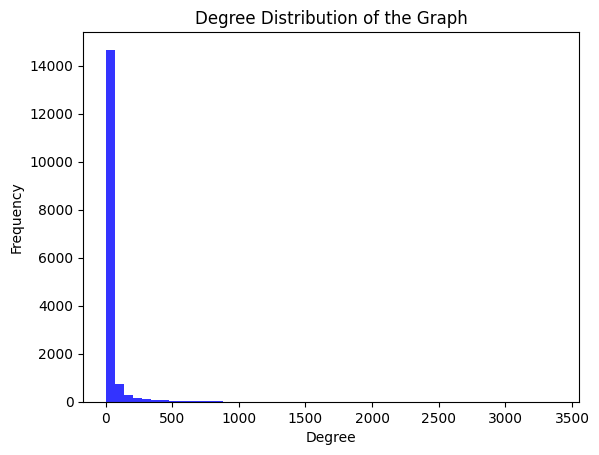

In [89]:
plt.hist(degrees, bins=50, color='blue', alpha=0.8)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.show()

### Community detection

In [ ]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [ ]:
communities = louvain_partitions(G)
len(communities)